In [1]:
import time
import numpy as np
import scipy
from scipy.optimize import minimize
import warnings
import commutators
import scipy.sparse
import scipy.optimize
import scipy.sparse.linalg
from itertools import combinations
from sys import argv
import itertools
import commutators #(Ryan Babbush)
import symbolicCircuits
import matplotlib.pyplot as plt
%matplotlib inline
import random

{0: [], 1: [], 2: [1], 3: []}
{0: [], 1: [0], 2: [1], 3: [2, 1]}


In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

#### Looking for a reduced sequence for VQE preparation in hydrogen

Now we will do H2 first because this is an easier target. For UCC singles and double in hydrogen we have 5 UCC operators. Every operator is represented by at most 8 unitary operations. Let's check:

In [3]:
H2UCCSD=symbolicCircuits.createExcitations(2,4,2)
circuitsH2=[]
depth=0
for x in H2UCCSD:
    term=symbolicCircuits.BKdiffJW(x,4)
    for t in term:
        print t.printTerm()
        depth += t.printTerm3()
        c = symbolicCircuits.getExpCircuit4(1.0,t)
        circuitsH2.append(c)
print depth

(0.5j, 'Y0I1X2I3')
(-0.5j, 'X0I1Y2I3')
(0.5j, 'Y0I1I2X3')
(-0.5j, 'X0I1I2Y3')
(0.5j, 'I0Y1X2I3')
(-0.5j, 'I0X1Y2I3')
(0.5j, 'I0Y1I2X3')
(-0.5j, 'I0X1I2Y3')
(0.125j, 'Y0X1X2X3')
(0.125j, 'X0Y1X2X3')
(-0.125j, 'X0X1Y2X3')
(0.125j, 'Y0Y1Y2X3')
(-0.125j, 'X0X1X2Y3')
(0.125j, 'Y0Y1X2Y3')
(-0.125j, 'Y0X1Y2Y3')
(-0.125j, 'X0Y1Y2Y3')
544


/usr/lib/python2.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:339: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [4]:
# this check cancellations between two exponentiation circuits
# the order is important, here we suppose circuit2 is applied first
# so we check forward part of circuit1 and backward part of circuit2
# also a two-qubits gate takes twice the time of a single qubit gate
# so every two-qubits gate cancelled add two points while a single-qubit
# gate cancelled is just 1
def checkCancellations(c1,c2):
    c=c1+c2
    points=0
    nqubits=len(c2[0].pl)
    openPositions=0
    for n in range(0,nqubits):
        if c2[0].pl[n]==c1[0].pl[n]:
            openPositions+=1
            if c2[0].pl[n]!=['I']:
                points += 2
        else:
            break

    l1=len(c1[1]); l2=len(c2[1])
    mmin=min(l1,l2)
    if openPositions>1:
        for m in range(1,mmin+1):
            if len(c1[1][l1-m].pl)==nqubits:
                for n in range(nqubits-openPositions,nqubits):
                    #print c1[1][l1-m].pl,c2[1][l1-m].pl 
                    if c1[1][l1-m].pl[n]==c2[1][l2-m].pl[n] and c1[1][l1-m].pl[n]!=['I']:
                        points += 2
            elif len(c1[1][l1-m].pl)==nqubits-1:
                for n in range(nqubits-openPositions,nqubits-1):
                    # print c1[1][l1-m].pl,c2[1][l2-m].pl 
                    if c1[1][l1-m].pl[n]==c2[1][l2-m].pl[n] and c1[1][l1-m].pl[n]!=['I']:
                        points += 4
    # in the pretreatment of the terms we have already reduced the terms to terms that are all
    # different. So the backward part of one circuit will never cancel completely the forward part of another
    # (Fot this to happen the terms have to be identical)
    # Consequently, the above cases are all the possible scenerarios of cancellation 
    # without taking into account rearrangements of the gates integrating the exponentiation circuit
    return -1*points # we are going to minimize this

In [5]:
# examples
print checkCancellations(circuitsH2[10],circuitsH2[12]) # answer checked 8
print checkCancellations(circuitsH2[0],circuitsH2[15])  # answer checked 0
print checkCancellations(circuitsH2[0],circuitsH2[8])  # answer checked 4

-12
0
-2


In [6]:
def getTotalCancellations(sequence):
    points=0
    for n in range(0,len(sequence)-1):
        points += checkCancellations(sequence[n],sequence[n+1])
    return points

In [7]:
# example
print getTotalCancellations(circuitsH2)

-4


In [8]:
# implementing L permutations
def getPermutation(sequence,L):
    N=len(sequence)
    newsequence=sequence
    positions=range(0,N)
    # swap L times
    n=0
    while L>n and len(positions)>1:
        n+=1
        p=random.sample(positions,2)
        cir=newsequence[p[0]]
        newsequence[p[0]]=newsequence[p[1]]
        newsequence[p[1]]=cir        
        positions.remove(p[1])
        positions.remove(p[0])
    return newsequence

In [13]:
# example: swaping twice
newCircuitsH2=getPermutation(circuitsH2,6)
print getTotalCancellations(newCircuitsH2) 

-10


Now we work on the simulating annealing routine. For this case we programmed three options for the cooling schedule: logarithmic, exponential and geometrical. The number of flips performed is defined as the squared root of the temperature. We tried using L=temperature but convergence was too slow so we finally decided to take the squared root. We are not using any parameter to tune the 

In [141]:
# function for simulated annealing
# pathcities: array with our cities represented by their coordinates
# init_temp: initial temperature 
# thermostat: linear factor to decrease the temperature 
# ftol, itol, otol: tolerance values for stopping
# reannealing: schedule for reheating

def simulated_annealing( x_init, init_temp, thermostat, ftol, itol, otol, reannealing, optThermo=0):
    # ===============
    # SET THESE FOR DIAGNOSTICS
    # ================
    # setting otol with the minimum value N(N-1)
    
    m=100   
    #distsize=otol+1
    dist=[]
    temperature = init_temp   
    
    # number of accepted steps
    it = 0                    

    # COST HERE IS OUR ENERGY 
    prev_E = getTotalCancellations(x_init)
    
    # number of iterations
    atp=0
    
    didPlot = True
    
    while it >=0:
        ## NUMBER OF SWAPS
        L = np.max((np.ceil(np.sqrt(temperature)).astype(int),1))
        #L = np.max((np.floor(temperature).astype(int),1))
        #print "L", L
        #L = 2
        x_new = getPermutation(x_init, L)

        new_E = getTotalCancellations(x_new)
        deltaE  =  new_E -prev_E 

        if new_E < prev_E:
            x_init  = x_new
            #dist[it] =new_E
            dist.append(new_E)
            prev_E = new_E  
            it = it+1
            didPlot = False
            
        elif np.random.rand() < np.exp( -deltaE/temperature):
            x_init  = x_new
            #dist[it] =new_E
            dist.append(new_E)
            prev_E = new_E 
            it = it+1
            didPlot = False

        atp =atp +1;  # NUMBER OF ITERATIONS
        
        # check if it is time to cool down
        counter=0
        if it % reannealing == 0:
            counter +=1
            if optThermo==0:
                temperature = thermostat * temperature;
            elif optThermo==1:    
                temperature =  init_temp/np.log(np.e+counter);
            elif optThermo==2:    
                temperature =  init_temp*np.exp(-0.01*counter);
            compl_temp=0;
            
            #if we get too cold, reheat
            if temperature < 0.01:
                temperature = 0.1
        
        if False: #some optional plotting
            if (it % 100 == 0) and not didPlot:       
                display.clear_output()
                plt.plot( dist, '-r')
                display.display(plt.gcf())
                print len(dist)
                print raw_input('Iteration: ' + np.str(atp))
                plt.close()
                didPlot = True
    
        if len(dist)>m and abs(np.std(dist[-m:])/np.mean(dist[-m:])) < ftol:
            print np.std(dist[-m:])/np.mean(dist[-m:])
            print 'stopped with ftol'
            break
        if atp >itol:
            print 'stopped with itol'
            print 'atp:',atp
            break
        if len(dist)> 0 and dist[-1] < otol:
            print 'stopped with otol'
            print 'the cost of the last permutation is:',dist[-1]
            break
    
    return x_init, dist

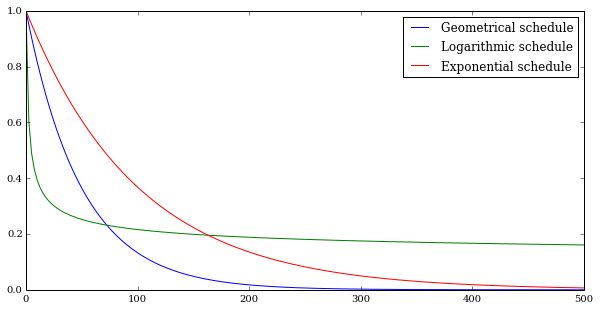

In [129]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)

fig=plt.figure(1,figsize=(10,5))
initT=1
values=np.linspace(0,500,200)
geometrical=initT*0.98**(values)
logarithmic=initT/np.log(values+np.e)
exponential=initT*np.exp(-0.01*values)
plt.plot(values,geometrical,label='Geometrical schedule')
plt.plot(values,logarithmic,label='Logarithmic schedule')
plt.plot(values,exponential,label='Exponential schedule')
plt.legend()
plt.show()

#### Simulating annealing to find the maximum number of cancellations for H2

Now we try our three ramps and calculate the minimum repeting the process ten times from random initial starting points. 

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


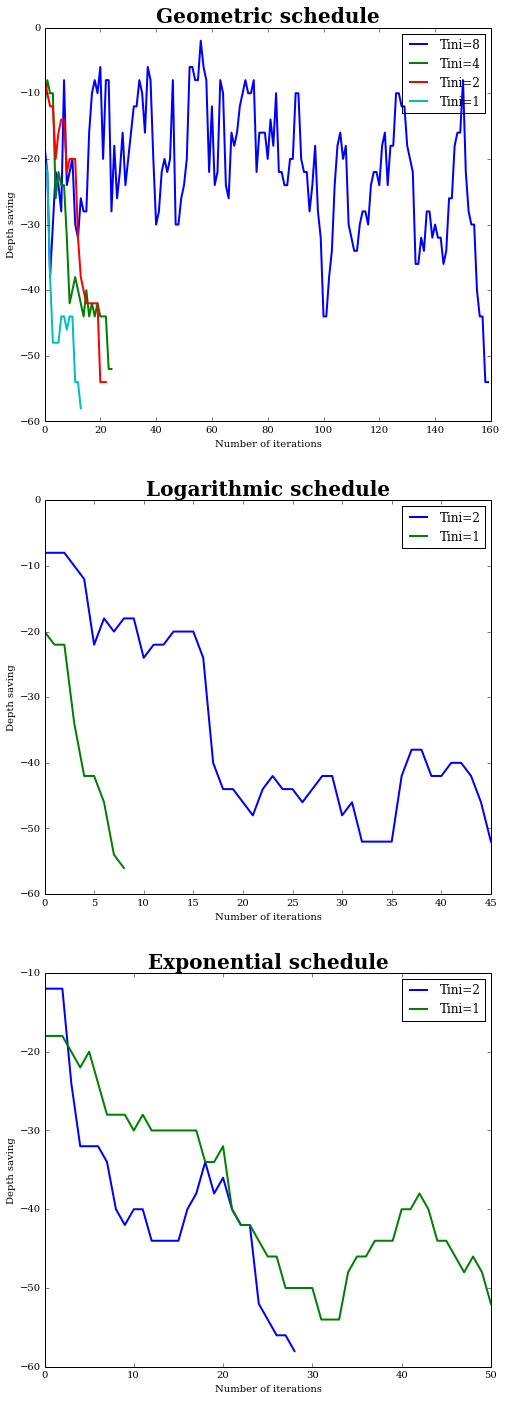

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


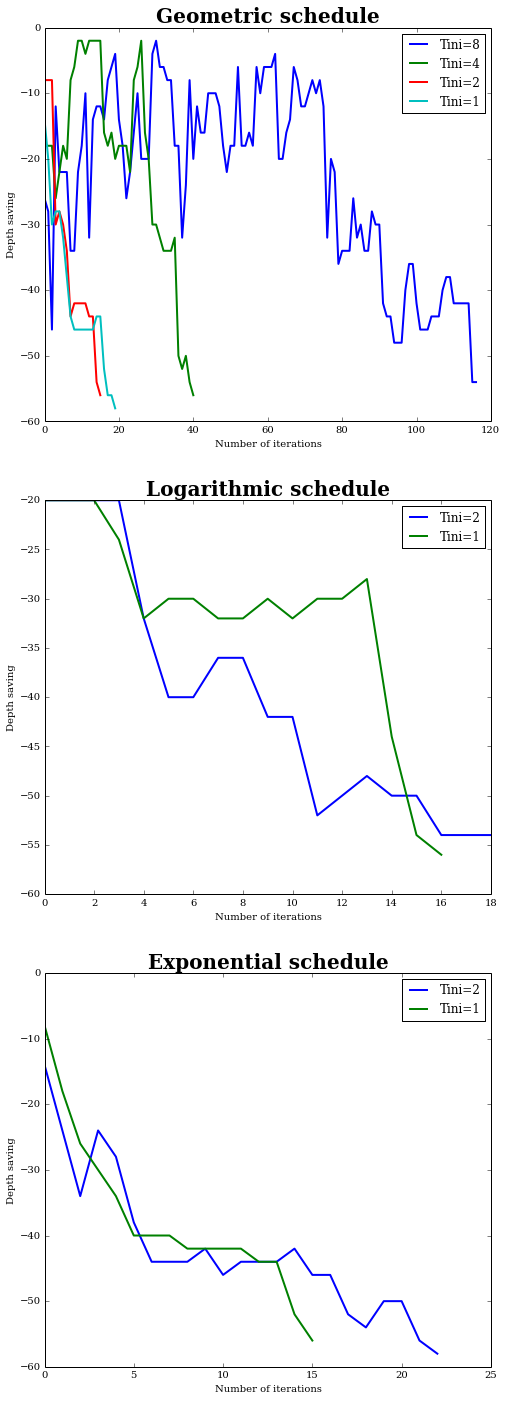

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


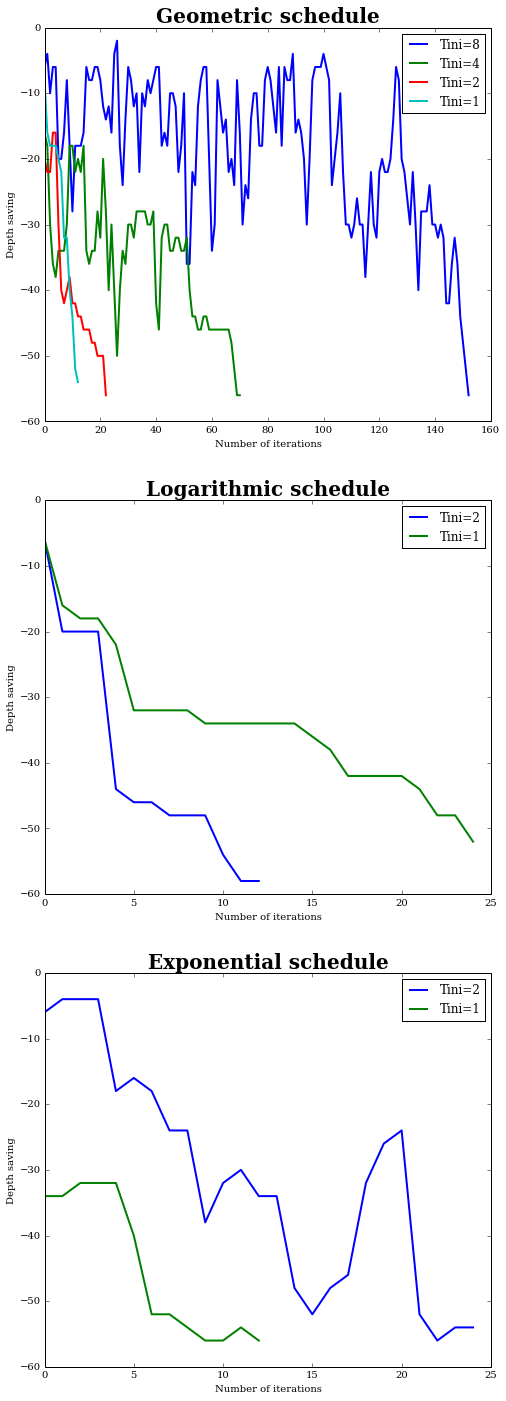

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


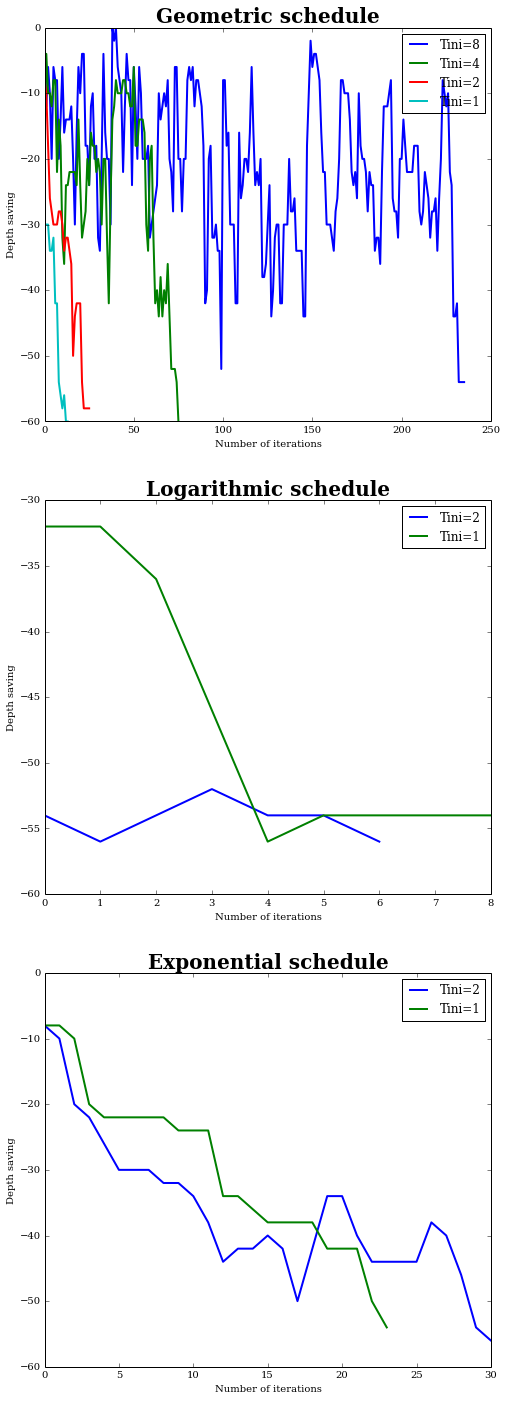

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


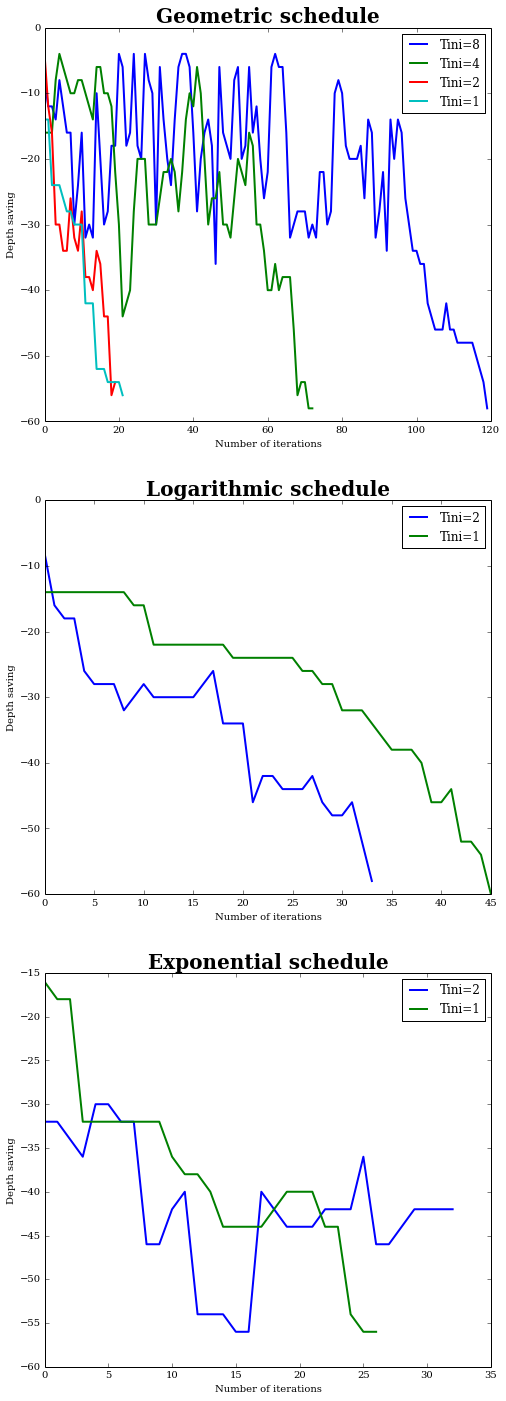

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


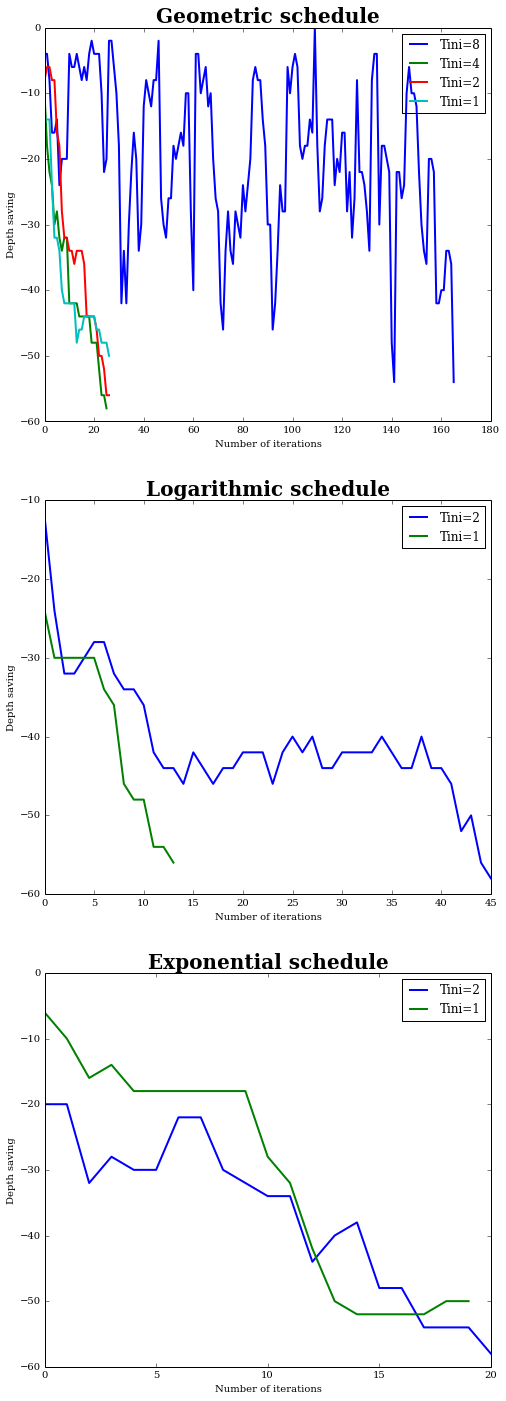

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


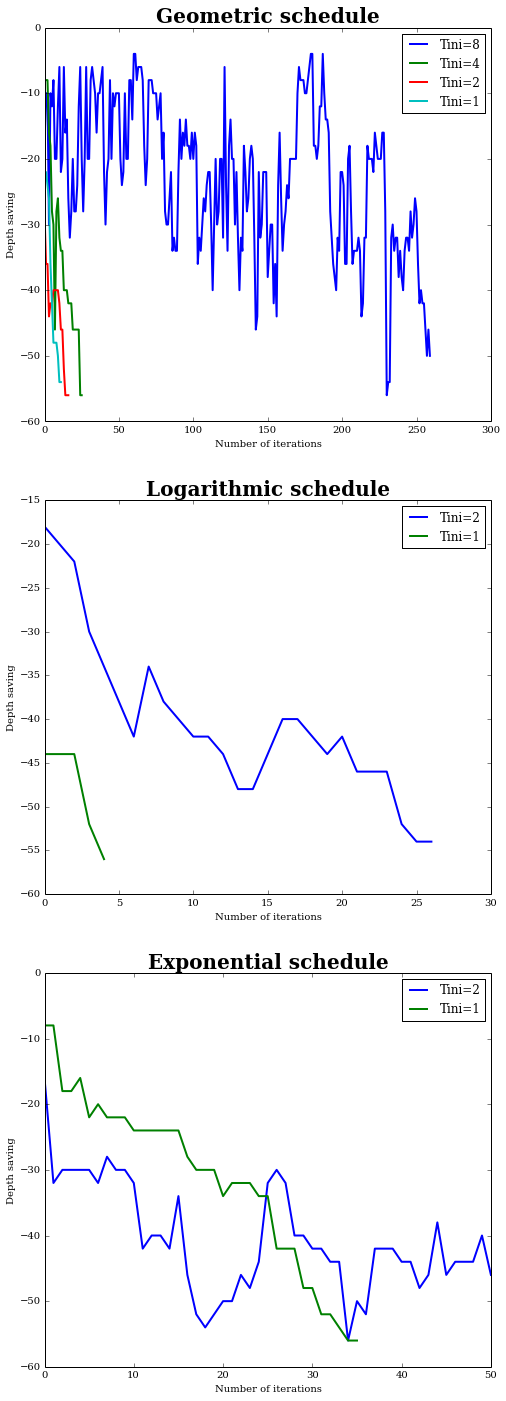

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


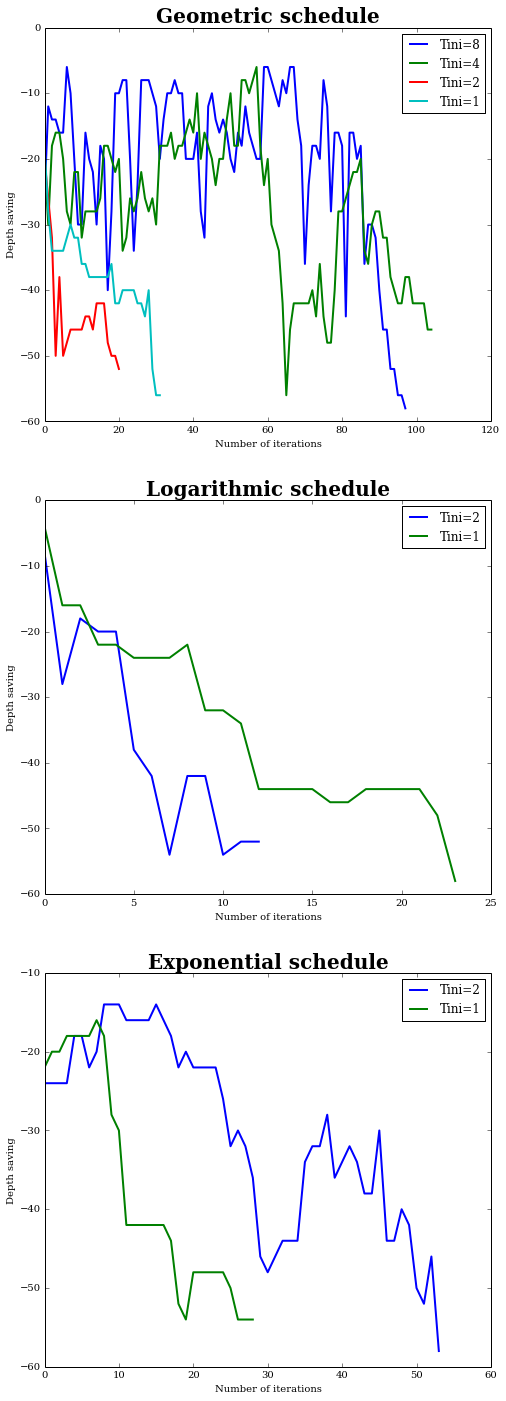

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


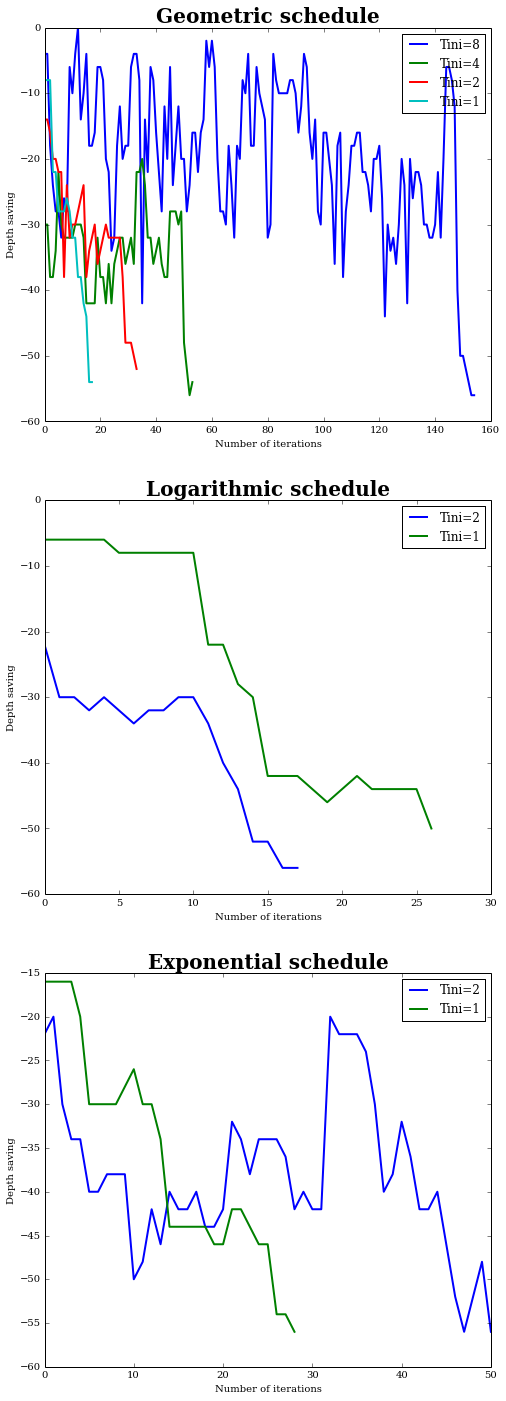

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


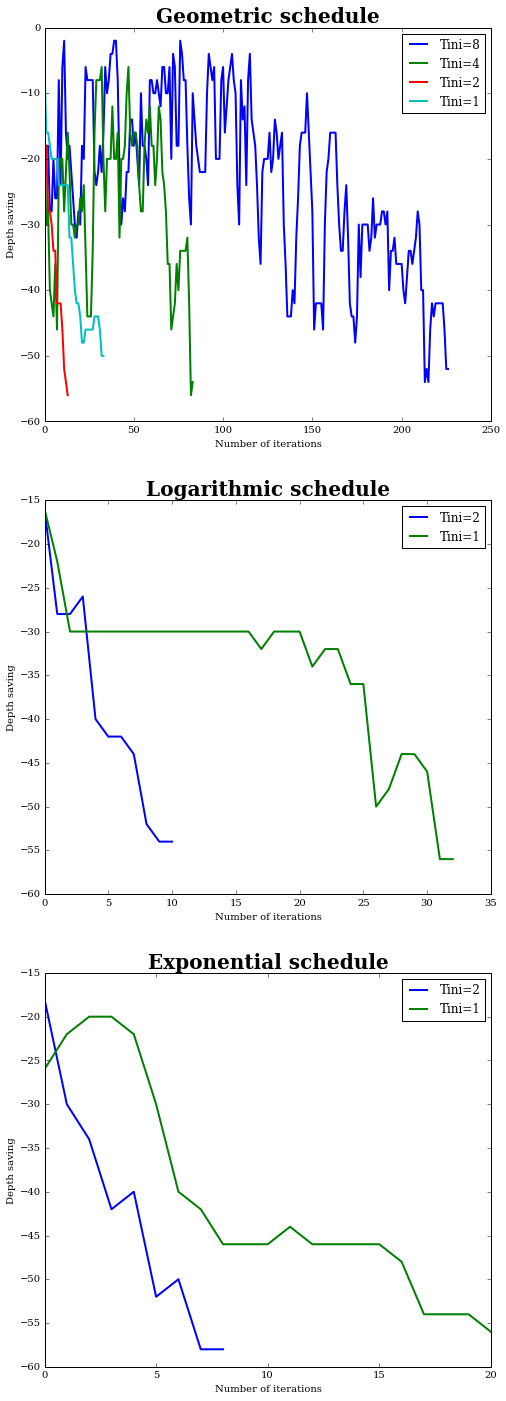

In [128]:
results=np.zeros((3,10))
minmin=0
for n in range(0,10):
    x_init=getPermutation(circuitsH2,8)
    plt.figure(1, figsize=(8,24))
    ramp=[' linear ramp',]
    temperatures=[[8,4,2,1],[2,1],[2,1]]
    for counter in range(0,3):
        if counter==0:
            ramp='Geometric schedule'
        elif counter==1:
            ramp='Logarithmic schedule'
        elif counter==2:
            ramp='Exponential schedule'
        minimum=0
        for T in temperatures[counter]:
            x_values, budgets = simulated_annealing(x_init, T, 0.98, 0.05, 20000, -200, 10, counter)
            if budgets[-1]<minimum:
                minimum=budgets[-1]
            if budgets[-1]<minmin:
                minmin=budgets[-1]
                x_min=x_values
            #print 'the algorithm takes: ',len(budgets),' iterations with T:',T
            plt.subplot(3, 1, counter+1)
            plt.title(ramp, fontsize=20, fontweight='bold')
            plt.plot(budgets, label='Tini='+str(T), linewidth=2.0)
            plt.ylabel('Depth saving'); plt.xlabel('Number of iterations')
            plt.legend()
            #print 'the lowest value found for T=',T,'is:',budgets[len(budgets)-1]
        results[counter,n]=minimum
    plt.show()

These are the results obtain from the three types of cooling schedule and the 10 repetitions:

In [130]:
print np.mean(results[0,:]),np.std(results[0,:])
print np.mean(results[1,:]),np.std(results[1,:])
print np.mean(results[2,:]),np.std(results[2,:])
print results

-57.4 1.28062484749
-57.0 1.3416407865
-57.0 1.0
[[-58. -58. -56. -60. -58. -58. -56. -58. -56. -56.]
 [-56. -56. -58. -56. -60. -58. -56. -58. -56. -56.]
 [-58. -58. -56. -56. -56. -58. -56. -58. -56. -58.]]


and this is the term with the maximum number of cancellations that we found:

In [132]:
print minmin
for x in x_min:
    counter=0
    for y in x:
        counter += 1
        if counter==2:
            for z in y:
                print z.printTerm()
        else:
            y.printTerm()
    print 

-60
(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0E1I2')
(1.0, 'I0B1b2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1I2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0E1I2')
(1.0, 'I0B1b2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1I2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2I3')

(1.0, 'I0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2

#### Now we do the same but for the BK mapping:

In [133]:
# Parity, Update and Flip sets for 4 qubits                                                                                                        
P4={3:[2,1],2:[1],1:[0],0:[]}
R4={3:[2,1],2:[1],1:[0],0:[]}
U4={3:[],2:[3],1:[3],0:[1,3]}
F4={3:[2,1],2:[],1:[0],0:[]}
# Creating remaining set
for n in range(0,4):
    for x in F4[n]:
        if x in R4[n]:
            R4[n].remove(x)

circuitsH2BK=[]
depth=0
for x in H2UCCSD:
    term=symbolicCircuits.BKdiff(x,P4,U4,F4,R4)
    for t in term:
        c = symbolicCircuits.getExpCircuit4(1.0,t)
        circuitsH2BK.append(c)
        depth+=t.printTerm3()
print 'Depth:',depth

Depth: 448


stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


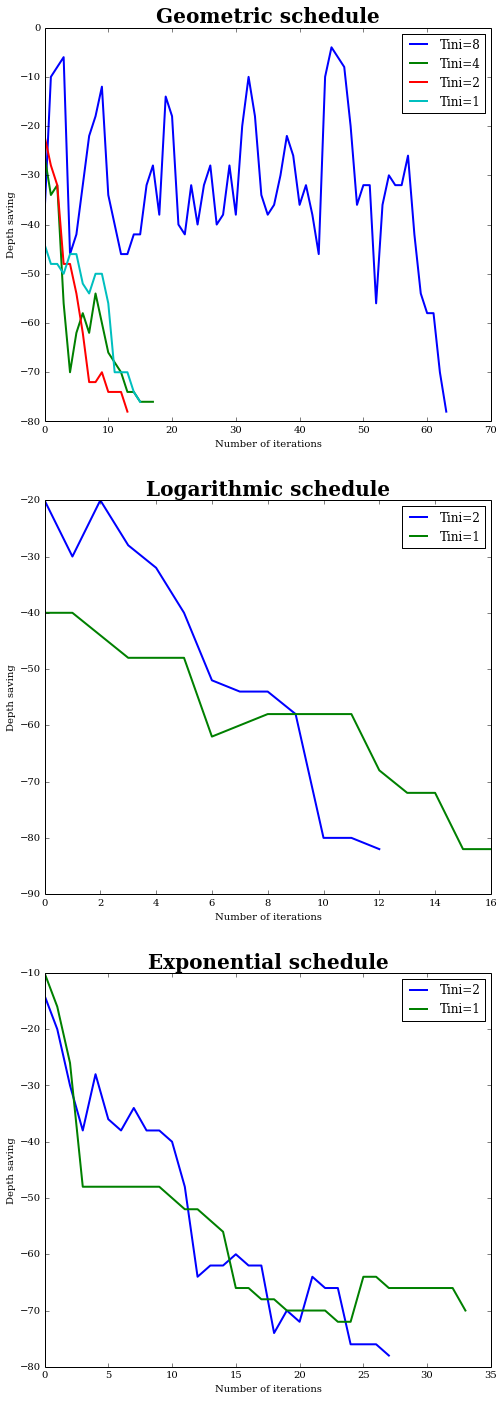

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


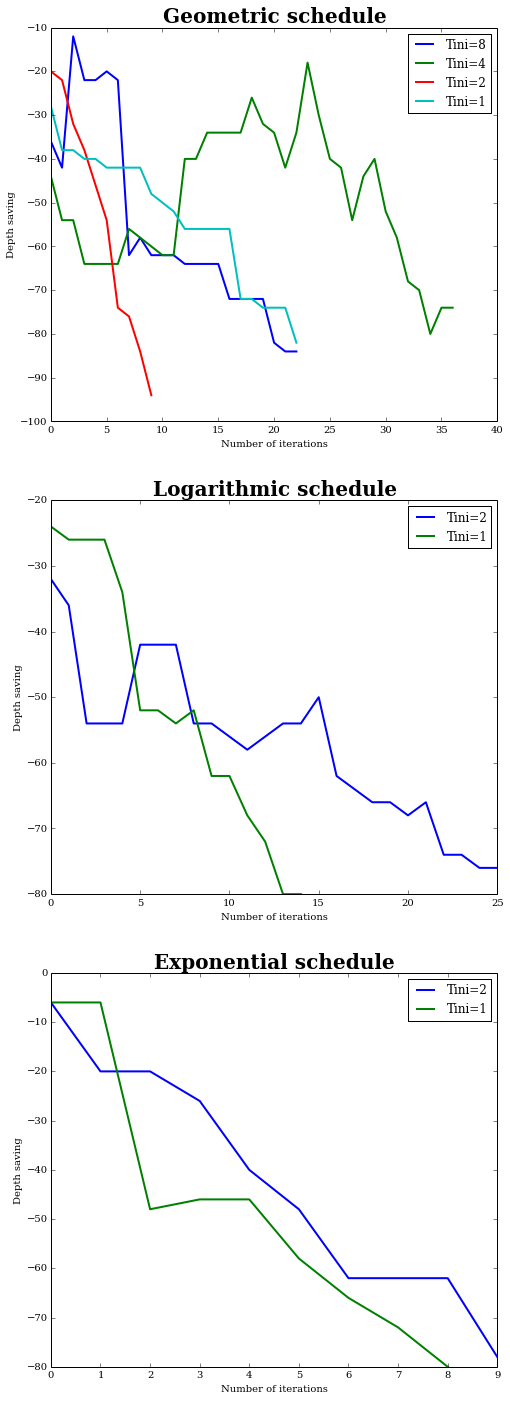

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


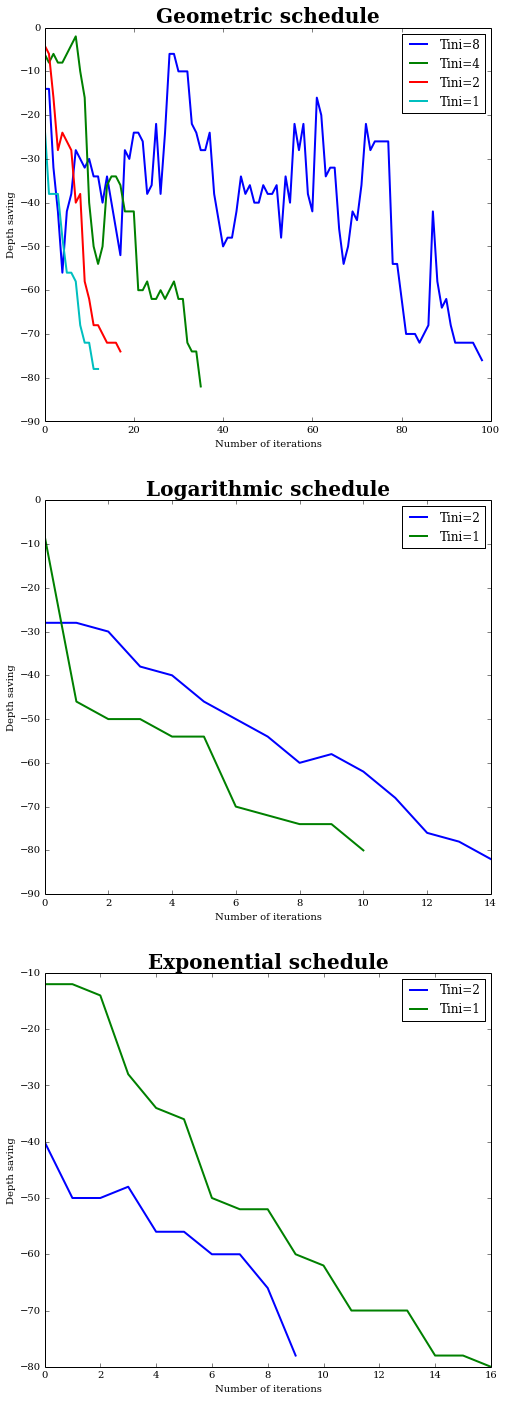

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


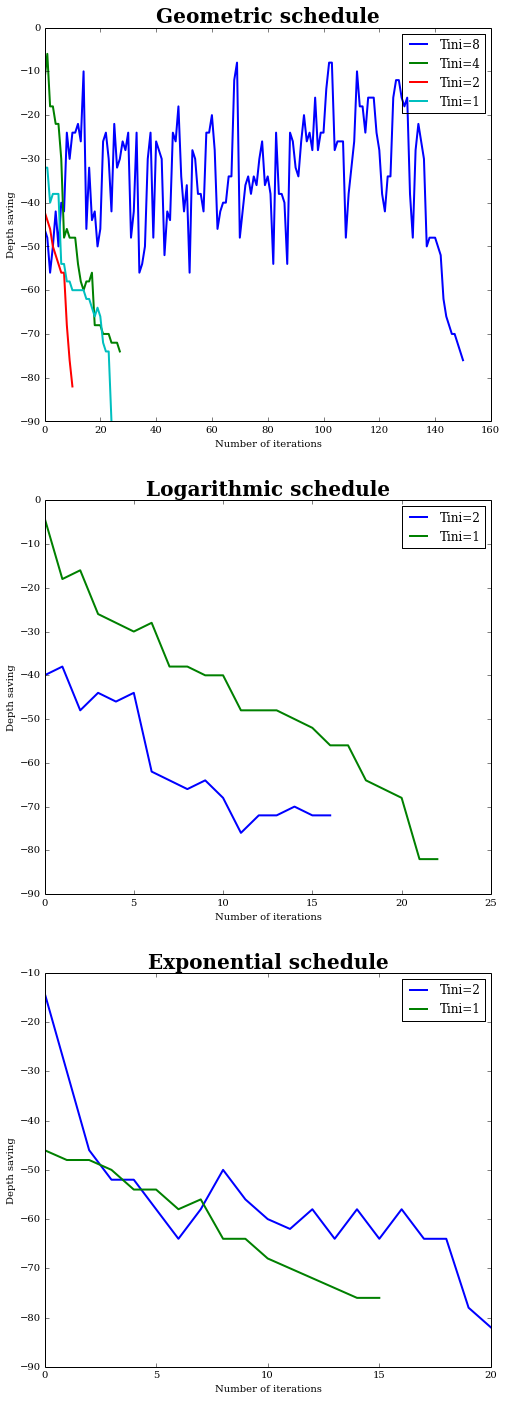

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


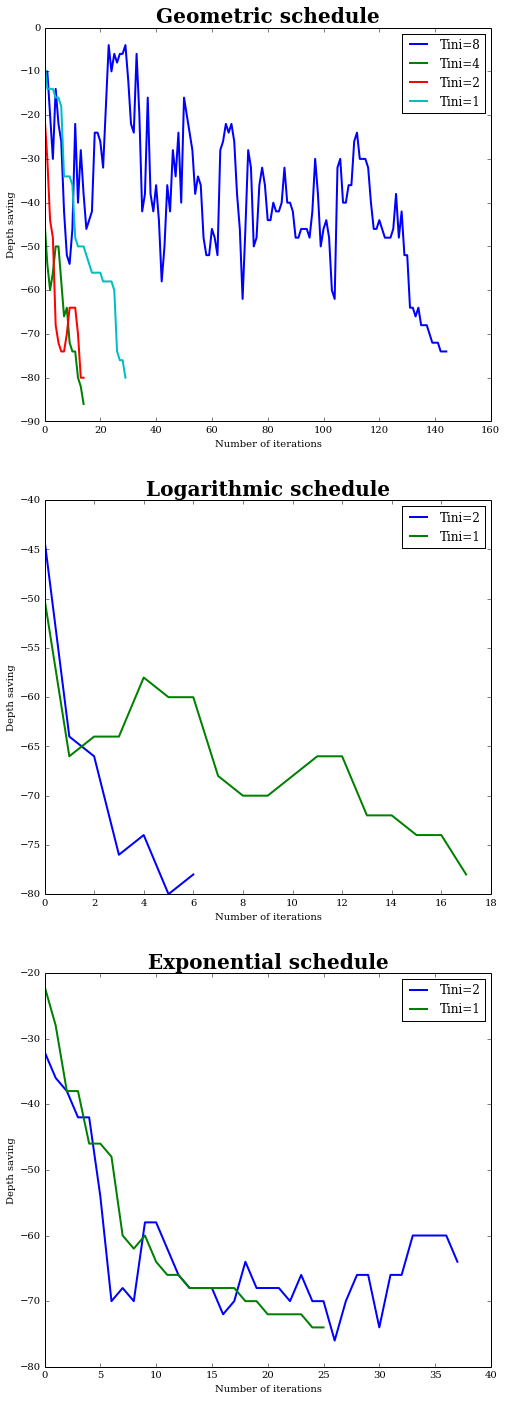

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


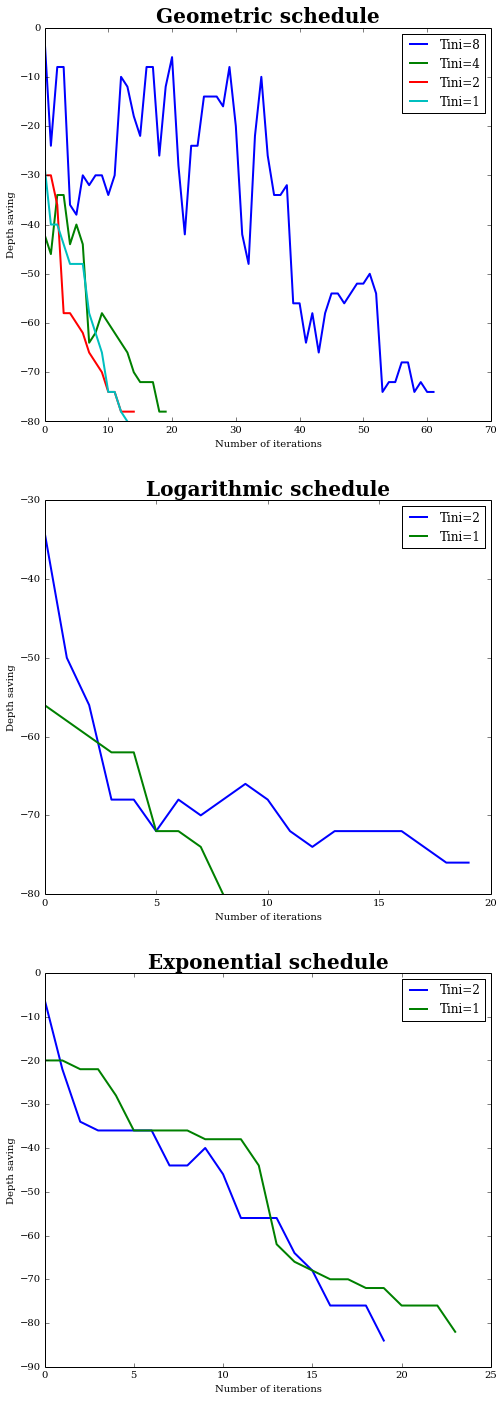

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


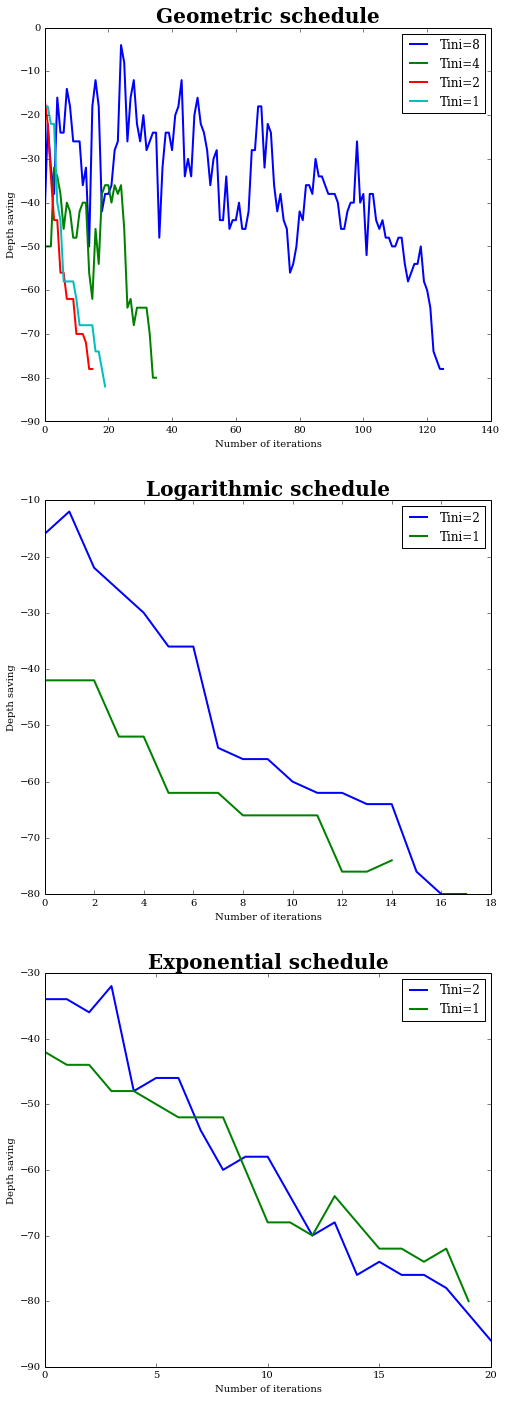

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


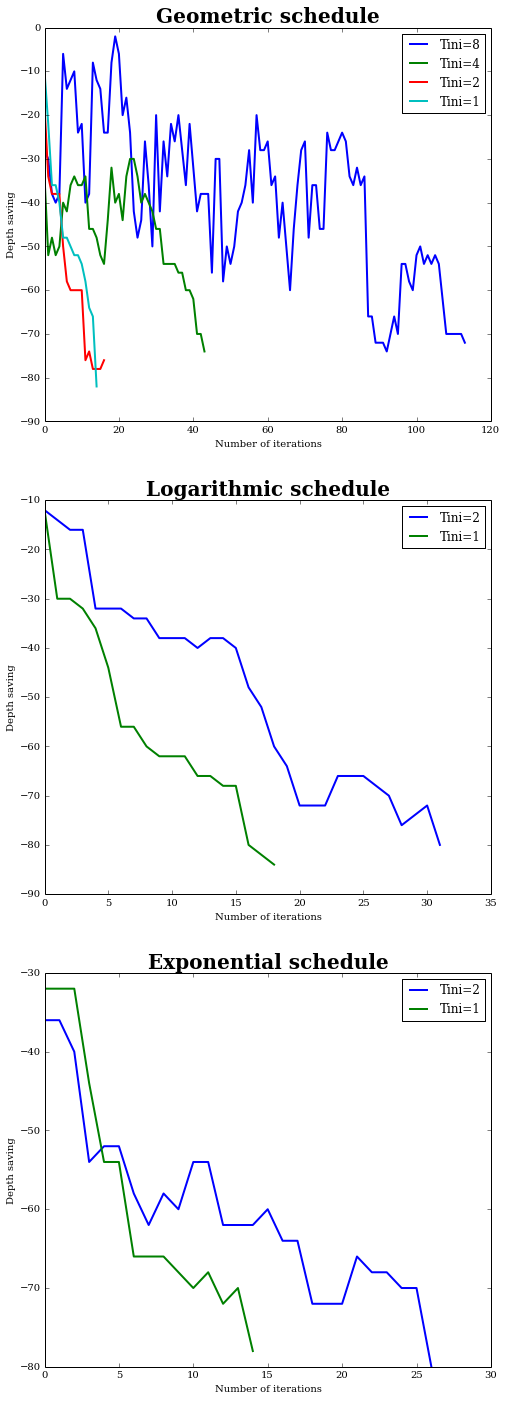

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


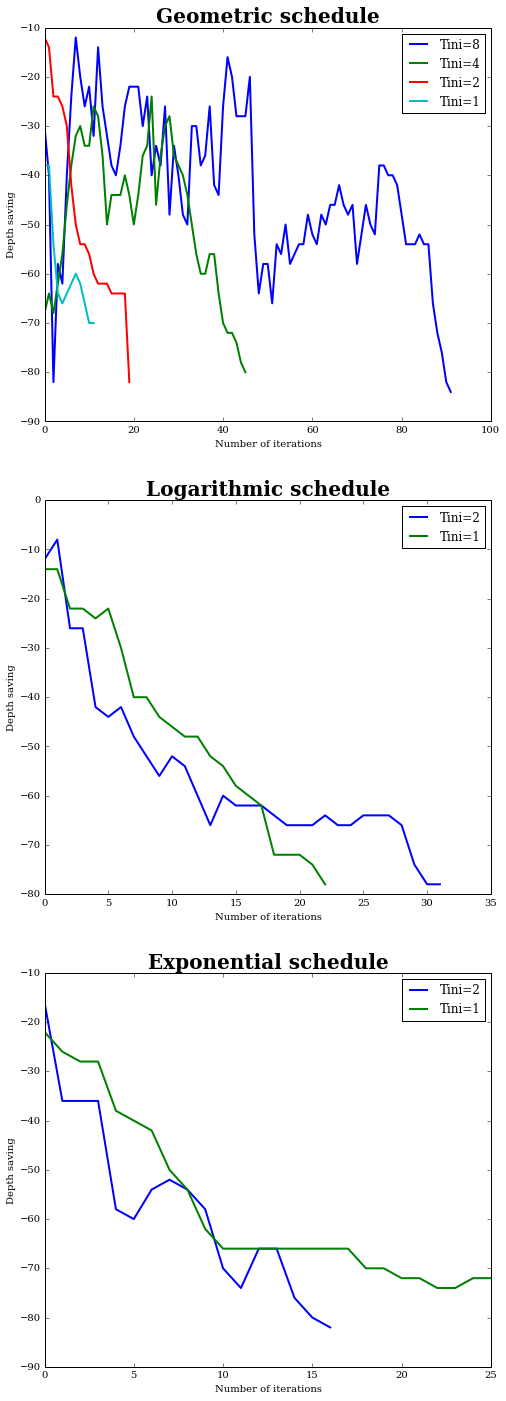

stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001
stopped with itol
atp: 20001


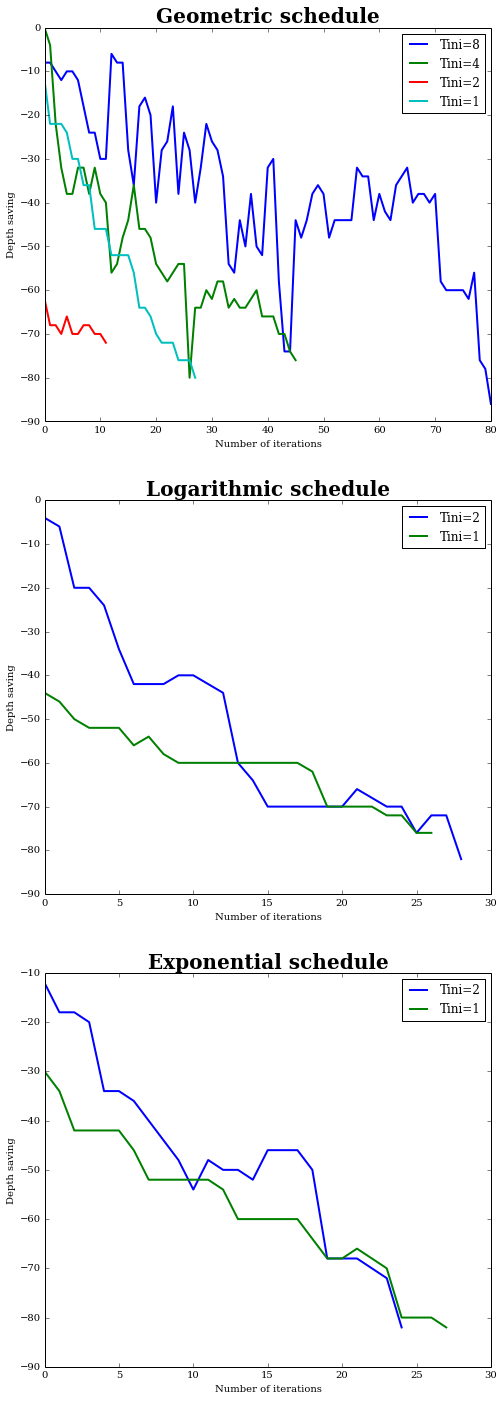

In [134]:
results=np.zeros((3,10))
minmin=0
for n in range(0,10):
    x_init=getPermutation(circuitsH2BK,8)
    plt.figure(1, figsize=(8,24))
    ramp=[' linear ramp',]
    temperatures=[[8,4,2,1],[2,1],[2,1]]
    for counter in range(0,3):
        if counter==0:
            ramp='Geometric schedule'
        elif counter==1:
            ramp='Logarithmic schedule'
        elif counter==2:
            ramp='Exponential schedule'
        minimum=0
        for T in temperatures[counter]:
            x_values, budgets = simulated_annealing(x_init, T, 0.98, 0.05, 20000, -200, 10, counter)
            if budgets[-1]<minimum:
                minimum=budgets[-1]
            if budgets[-1]<minmin:
                minmin=budgets[-1]
                x_min=x_values
            #print 'the algorithm takes: ',len(budgets),' iterations with T:',T
            plt.subplot(3, 1, counter+1)
            plt.title(ramp, fontsize=20, fontweight='bold')
            plt.plot(budgets, label='Tini='+str(T), linewidth=2.0)
            plt.ylabel('Depth saving'); plt.xlabel('Number of iterations')
            plt.legend()
            #print 'the lowest value found for T=',T,'is:',budgets[len(budgets)-1]
        results[counter,n]=minimum
    plt.show()

In [135]:
print np.mean(results[0,:]),np.std(results[0,:])
print np.mean(results[1,:]),np.std(results[1,:])
print np.mean(results[2,:]),np.std(results[2,:])
print results

-84.4 4.54312667664
-80.8 1.83303027798
-80.8 3.12409987036
[[-78. -94. -82. -90. -86. -80. -82. -82. -84. -86.]
 [-82. -80. -82. -82. -78. -80. -80. -84. -78. -82.]
 [-78. -80. -80. -82. -74. -84. -86. -80. -82. -82.]]


In [136]:
print minmin
for x in x_min:
    counter=0
    for y in x:
        counter += 1
        if counter==2:
            for z in y:
                print z.printTerm()
        else:
            y.printTerm()
    print 

-94
(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0E1I2')
(1.0, 'I0B1b2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2B3')
(1.0, 'I0I1E2')
(1.0, 'I0I1B2b3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1I2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1I2I3')

(1.0, 'I0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2B3')
(1.0, 'I0I1E2')
(1.0, 'I0I1B2b3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1I2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0E1I2')
(1.0, 'I0B1b2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1B2I3')
(1.0, 'I0I1E2')
(1.0, 'I0I1b2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2I3')
(1.0, 'I0E1I2')
(1.0, 'I0b1I2I3')

(1.0, 'B0I1I2I3')
(1.0, 'E0I1I2')
(1.0, 'b0B1I2

#### A more complicated example: VQE for lithium hydride in 8 qubits.

In [137]:
LiHUCCSD=symbolicCircuits.createExcitations(4,8,2)
print LiHUCCSD

[[5, -1], [6, -1], [7, -1], [8, -1], [5, -2], [6, -2], [7, -2], [8, -2], [5, -3], [6, -3], [7, -3], [8, -3], [5, -4], [6, -4], [7, -4], [8, -4], [6, 5, -2, -1], [7, 5, -2, -1], [8, 5, -2, -1], [7, 6, -2, -1], [8, 6, -2, -1], [8, 7, -2, -1], [6, 5, -3, -1], [7, 5, -3, -1], [8, 5, -3, -1], [7, 6, -3, -1], [8, 6, -3, -1], [8, 7, -3, -1], [6, 5, -4, -1], [7, 5, -4, -1], [8, 5, -4, -1], [7, 6, -4, -1], [8, 6, -4, -1], [8, 7, -4, -1], [6, 5, -3, -2], [7, 5, -3, -2], [8, 5, -3, -2], [7, 6, -3, -2], [8, 6, -3, -2], [8, 7, -3, -2], [6, 5, -4, -2], [7, 5, -4, -2], [8, 5, -4, -2], [7, 6, -4, -2], [8, 6, -4, -2], [8, 7, -4, -2], [6, 5, -4, -3], [7, 5, -4, -3], [8, 5, -4, -3], [7, 6, -4, -3], [8, 6, -4, -3], [8, 7, -4, -3]]


In [138]:
circuitsLiH=[]
depth=0
for x in LiHUCCSD:
    term=symbolicCircuits.BKdiffJW(x,8)
    for t in term:
        c = symbolicCircuits.getExpCircuit4(1.0,t)
        circuitsLiH.append(c)
        depth += t.printTerm3()
print 'The depth of the circuit is:',depth

The depth of the circuit is: 30336


In [50]:
print len(circuitsLiH)

320


stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


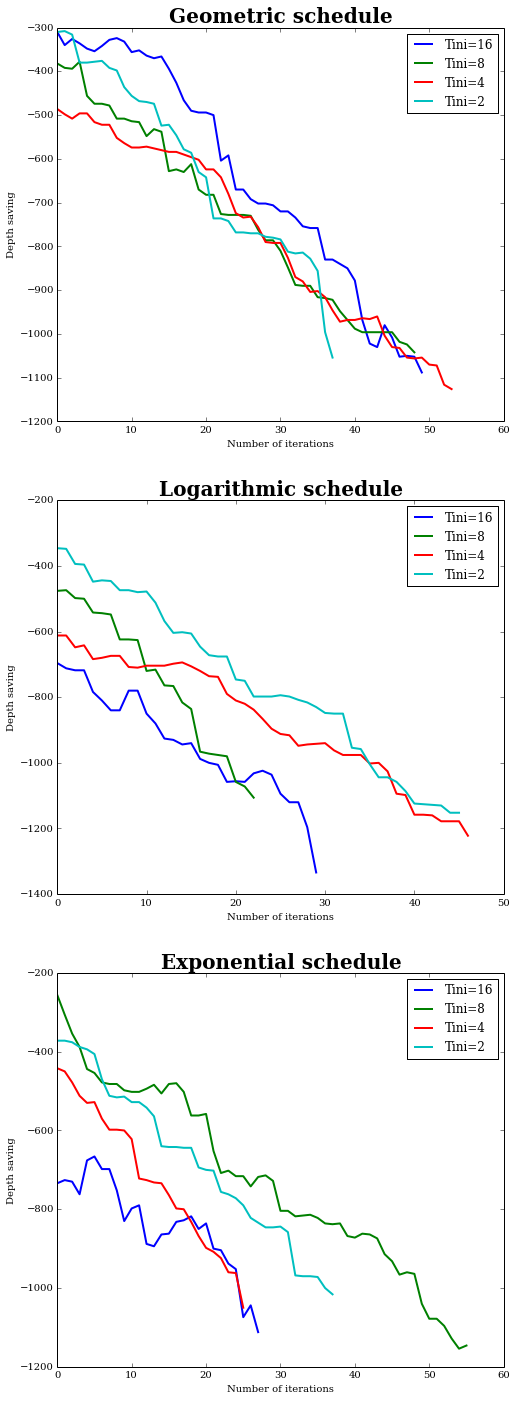

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


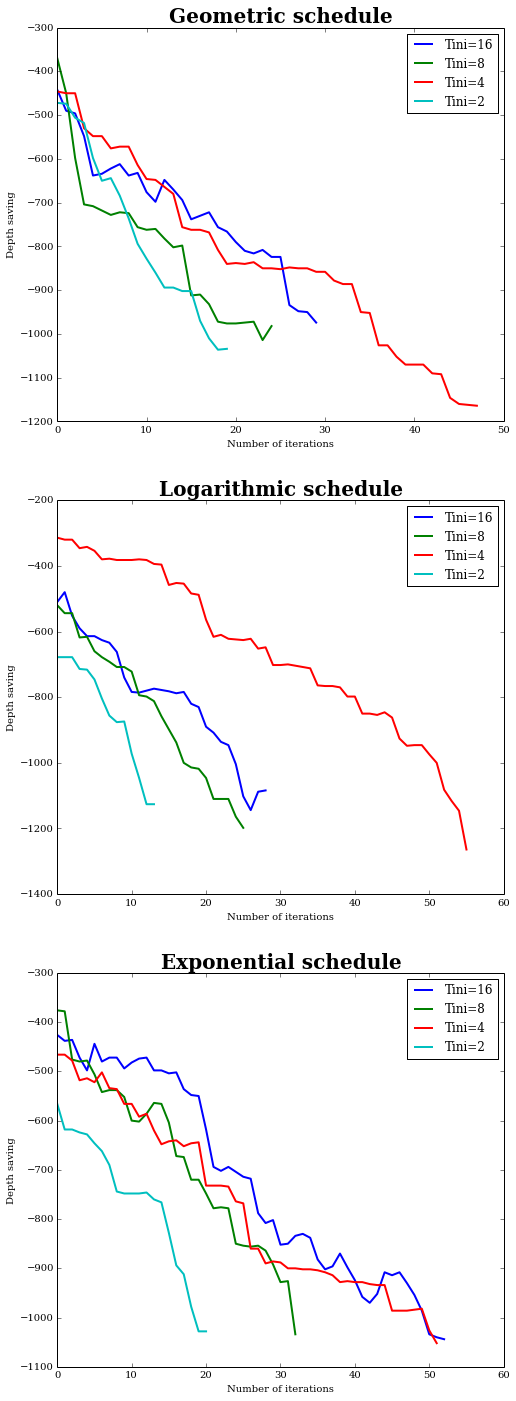

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


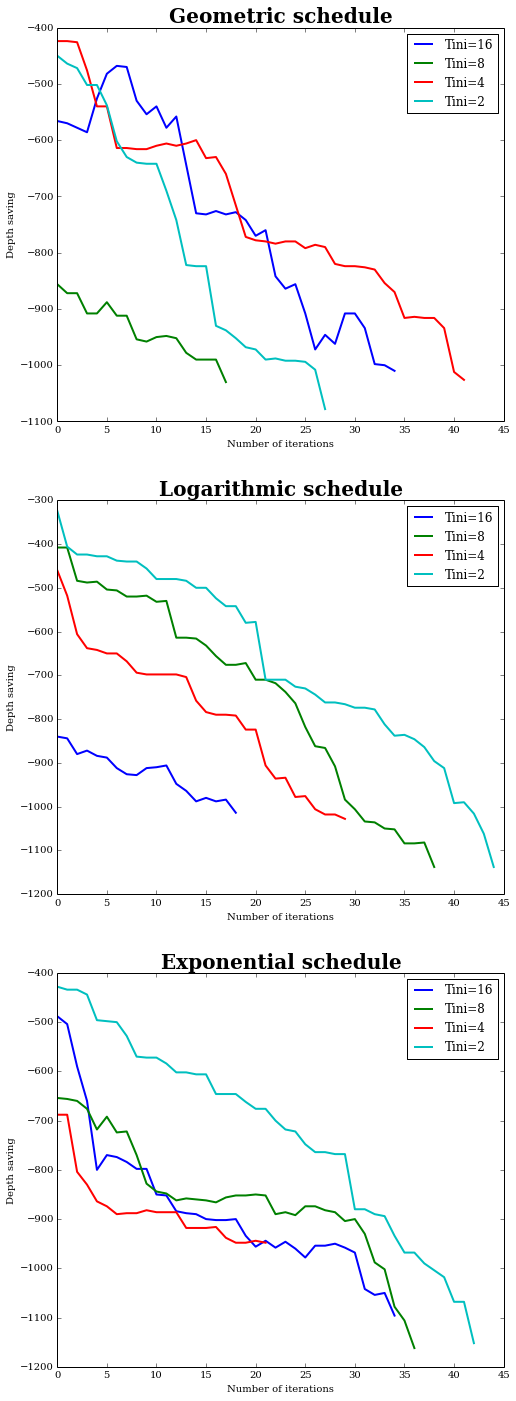

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


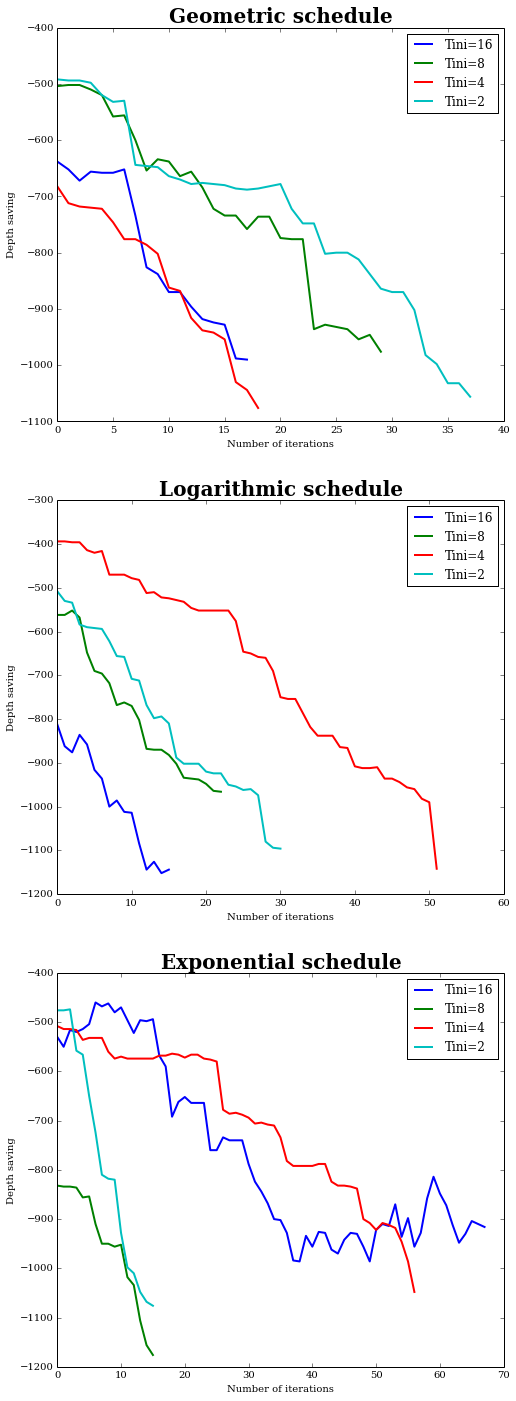

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


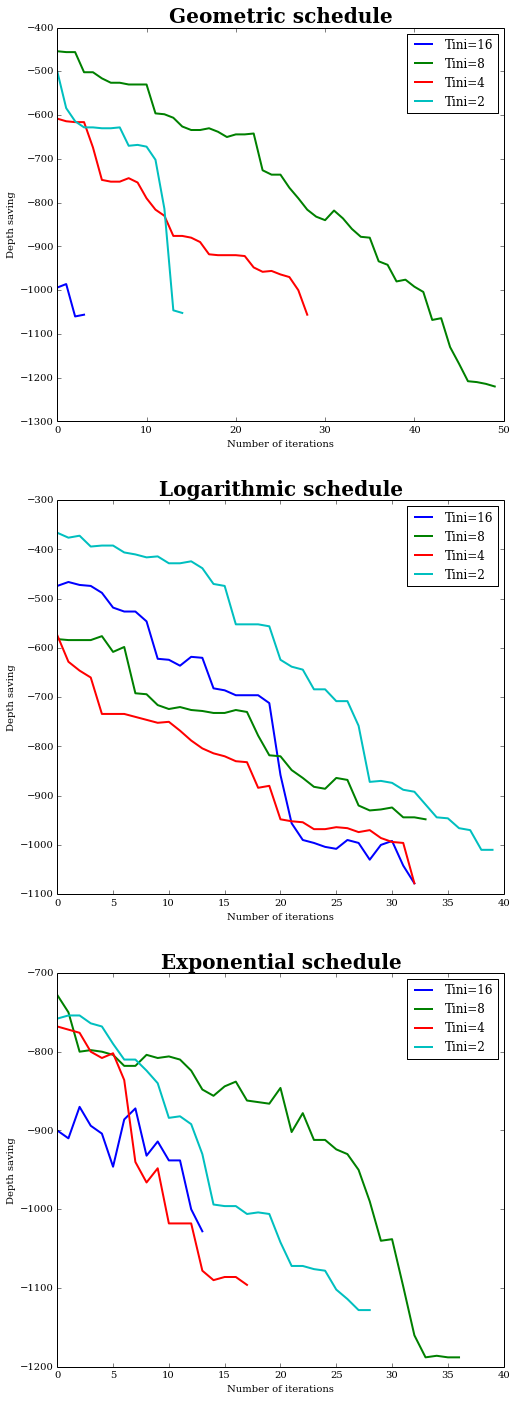

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


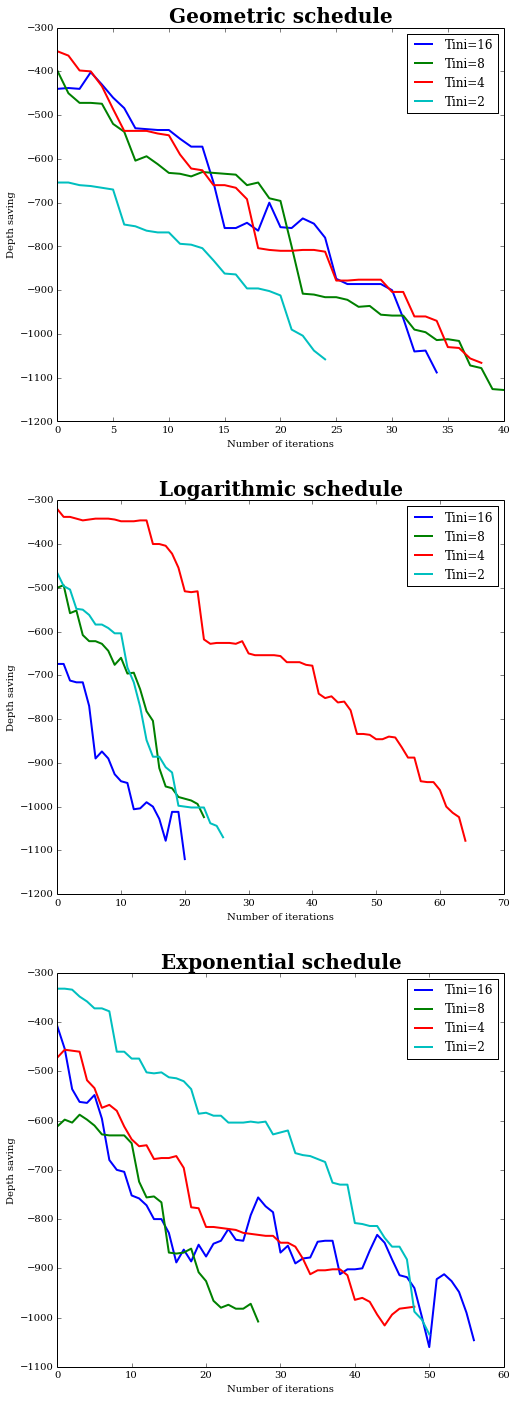

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


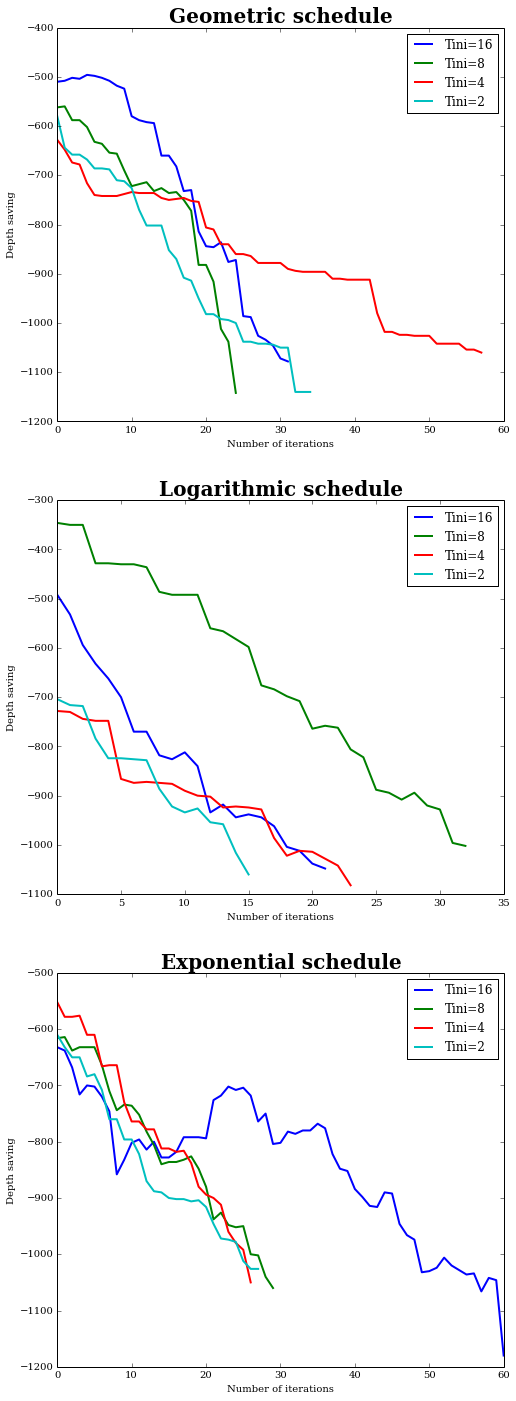

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


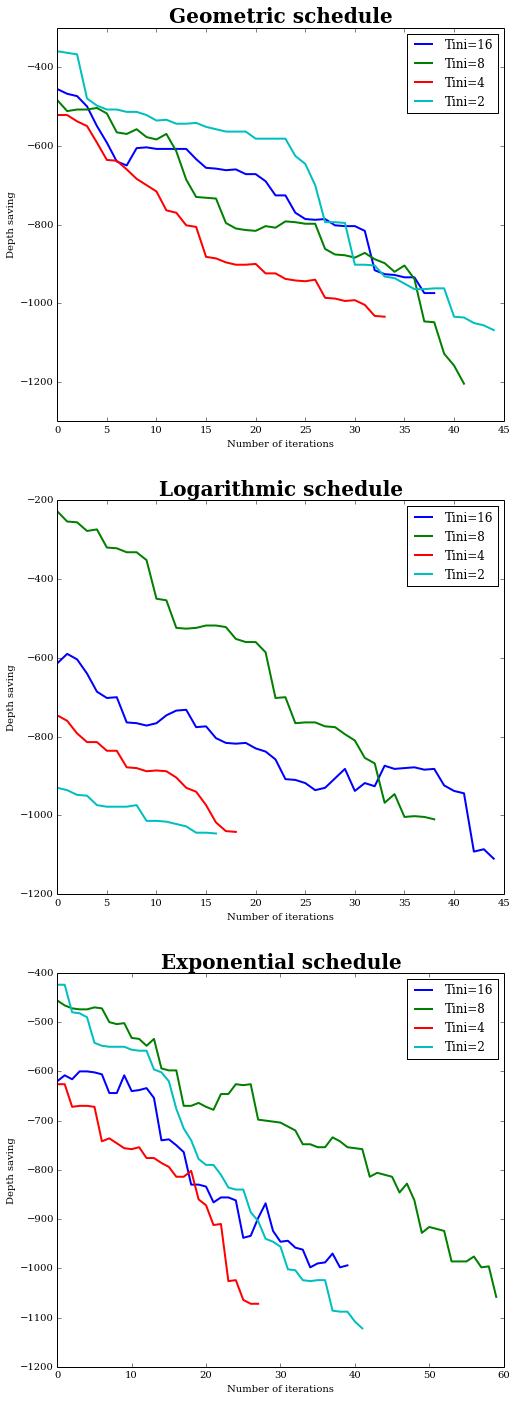

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


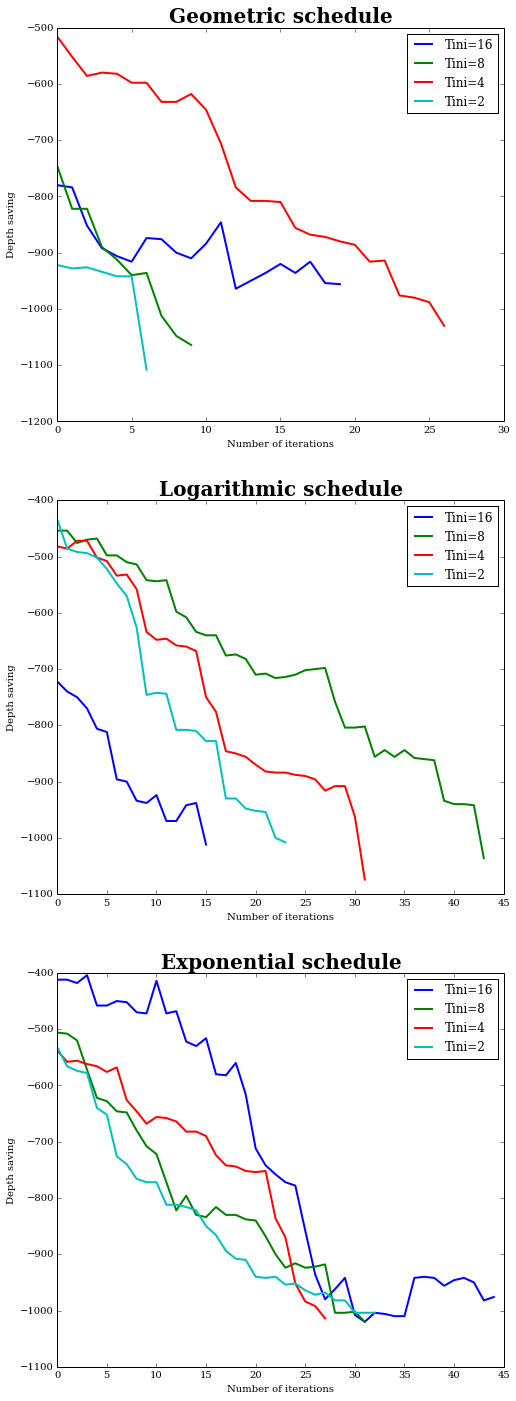

stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001
stopped with itol
atp: 10001


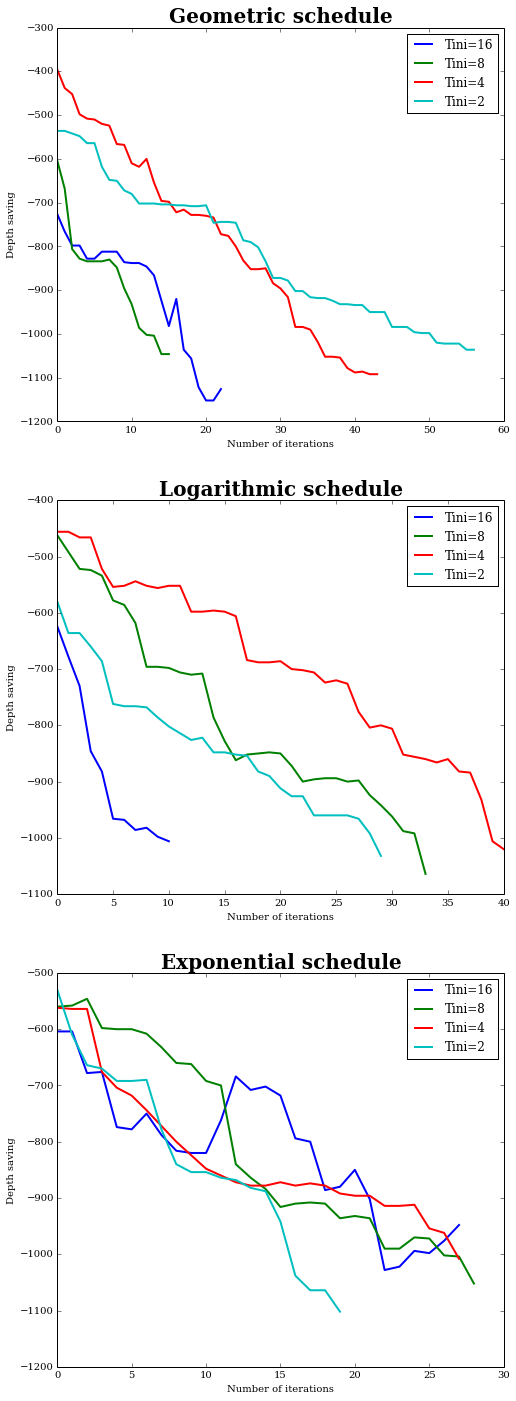

In [144]:
results=np.zeros((3,10))
minmin=0
for n in range(0,10):
    x_init=getPermutation(circuitsLiH,160)
    plt.figure(1, figsize=(8,24))
    ramp=[' linear ramp',]
    temperatures=[[16,8,4,2],[16,8,4,2],[16,8,4,2]]
    for counter in range(0,3):
        if counter==0:
            ramp='Geometric schedule'
        elif counter==1:
            ramp='Logarithmic schedule'
        elif counter==2:
            ramp='Exponential schedule'
        minimum=0
        for T in temperatures[counter]:
            x_values, budgets = simulated_annealing(x_init, T, 0.98, 0.05, 10000, -10000, 10, counter)
            if budgets[-1]<minimum:
                minimum=budgets[-1]
            if budgets[-1]<minmin:
                minmin=budgets[-1]
                x_min=x_values
            #print 'the algorithm takes: ',len(budgets),' iterations with T:',T
            plt.subplot(3, 1, counter+1)
            plt.title(ramp, fontsize=20, fontweight='bold')
            plt.plot(budgets, label='Tini='+str(T), linewidth=2.0)
            plt.ylabel('Depth saving'); plt.xlabel('Number of iterations')
            plt.legend()
            #print 'the lowest value found for T=',T,'is:',budgets[len(budgets)-1]
        results[counter,n]=minimum
    plt.show()

#### Do we see differences with other kind of mapping?

In [63]:
# Parity, Update and Flip sets for 8 qubits                                                                                                        
P8={7:[6,5,3],6:[5,3],5:[4,3],4:[3],3:[2,1],2:[1],1:[0],0:[]}
R8={7:[6,5,3],6:[5,3],5:[4,3],4:[3],3:[2,1],2:[1],1:[0],0:[]}
U8={7:[],6:[7],5:[7],4:[5,7],3:[7],2:[3,7],1:[3,7],0:[1,3,7]}
F8={7:[6,5,3],6:[],5:[4],4:[],3:[2,1],2:[],1:[0],0:[]}
# Creating remaining set
for n in range(0,8):
    for x in F8[n]:
        if x in R8[n]:
            R8[n].remove(x)

circuitsLiHBK=[]
depth=0
for x in LiHUCCSD:
    term=symbolicCircuits.BKdiff(x,P8,U8,F8,R8)
    for t in term:
        c = symbolicCircuits.getExpCircuit4(1.0,t)
        circuitsLiHBK.append(c)
        depth += t.printTerm3()
print 'The depth of the circuit is:',depth

The depth of the circuit is: 24384


In [64]:
print len(circuitsLiHBK)

320


stopped with itol
atp: 20001
the algorithm takes:  0  iterations with T: 10
the lowest value found for T= 10 is:

IndexError: list index out of range

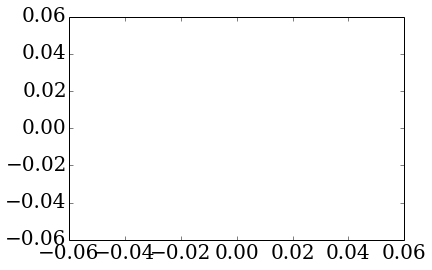

In [65]:
#x_init=getPermutation(circuitsLiHBK,160)
x_init=circuitsLiHBK
for counter in range(0,2):
    temperatures=[10,40,80,160]
    for T in temperatures:
        x_values, budgets = simulated_annealing(x_init, T, 0.95, 0.05, 20000, -15000, 10, counter)
        print 'the algorithm takes: ',len(budgets),' iterations with T:',T
        plt.plot(budgets)
        print 'the lowest value found for T=',T,'is:',budgets[len(budgets)-1]
    plt.show()

#### Examining phase estimation

In [66]:
molecule='LiH'
basis='NMO-8'
coeff,op=commutators.GetHamiltonianTerms(molecule, basis, add_conjugates=True, path='/home/jonathan/quantum_computation/data/')
hamiltonian=symbolicCircuits.getHamiltonian(coeff,op,P8,U8,F8,R8)
print len(hamiltonian)
counter=0
depth=0
PELiH=[]
for t in hamiltonian:
    depth += t.printTerm3()
    c = symbolicCircuits.getExpCircuit4(1.0,t)
    PELiH.append(c)
print 'The depth of the circuit',depth

 193
The depth of the circuit 10672


stopped with itol
atp: 10001
the algorithm takes:  294  iterations with T: 45
the lowest value found for T= 45 is: -414
stopped with itol
atp: 10001
the algorithm takes:  130  iterations with T: 30
the lowest value found for T= 30 is: -466
stopped with itol
atp: 10001
the algorithm takes:  41  iterations with T: 15
the lowest value found for T= 15 is: -412
stopped with itol
atp: 10001
the algorithm takes:  79  iterations with T: 5
the lowest value found for T= 5 is: -436
stopped with itol
atp: 10001
the algorithm takes:  60  iterations with T: 45
the lowest value found for T= 45 is: -384
stopped with itol
atp: 10001
the algorithm takes:  74  iterations with T: 30
the lowest value found for T= 30 is: -402
stopped with itol
atp: 10001
the algorithm takes:  112  iterations with T: 15
the lowest value found for T= 15 is: -438
stopped with itol
atp: 10001
the algorithm takes:  118  iterations with T: 5
the lowest value found for T= 5 is: -418


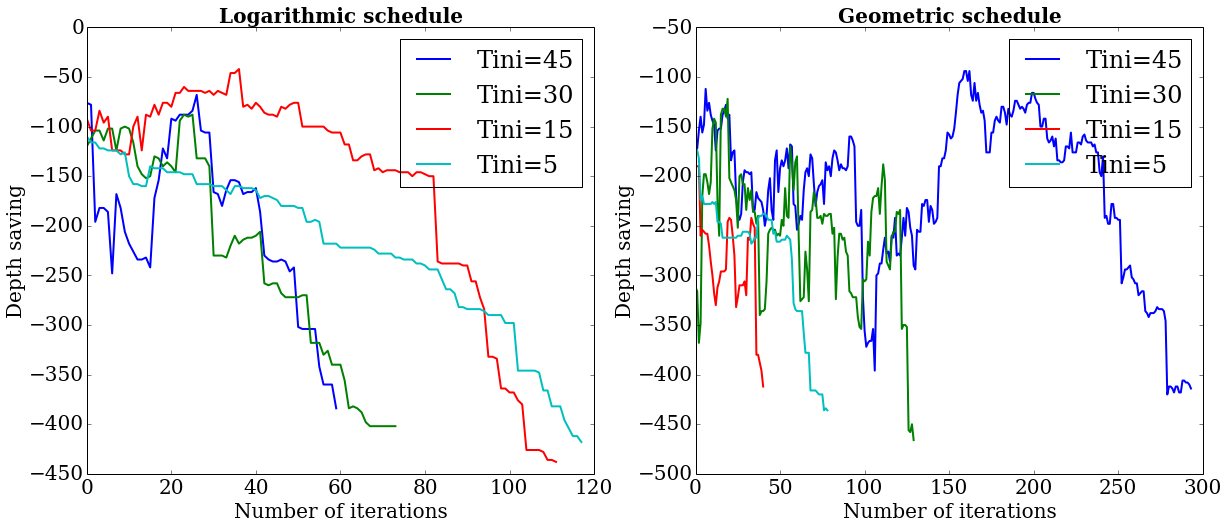

In [74]:
x_init=PELiH
plt.figure(1, figsize=(20,8))
ramp=[' linear ramp',]
temperatures=[[45,30,15,5],[45,30,15,5]]
for counter in range(0,2):
    if counter==0:
        ramp='Geometric schedule'
    elif counter==1:
        ramp='Logarithmic schedule'
    for T in temperatures[counter]:
        x_values, budgets = simulated_annealing(x_init, T, 0.95, 0.05, 10000, -5000, 10, counter)
        print 'the algorithm takes: ',len(budgets),' iterations with T:',T
        plt.subplot(1, 2, counter)
        plt.title(ramp, fontsize=20, fontweight='bold')
        plt.plot(budgets, label='Tini='+str(T), linewidth=2.0)
        plt.ylabel('Depth saving'); plt.xlabel('Number of iterations')
        plt.legend()
        print 'the lowest value found for T=',T,'is:',budgets[len(budgets)-1]
plt.show()

In [60]:
hamiltonianLiHJW=symbolicCircuits.getHamiltonianJW(coeff,op,8)
print len(hamiltonianLiHJW)
counter=0
depth=0
PELiHJW=[]
counter=0
for t in hamiltonianLiHJW:
    counter += 1
    if counter!=1:
        depth += t.printTerm3()
        c = symbolicCircuits.buildExpCircuit3(1.0,t)
        PELiHJW.append(c)
print 'The depth of the circuit',depth

193
The depth of the circuit 17168


stopped with ftol
the algorithm takes:  1001  iterations with T: 1
the lowest value found for T= 1 is: -792
stopped with ftol
the algorithm takes:  1001  iterations with T: 25
the lowest value found for T= 25 is: -792
stopped with ftol
the algorithm takes:  1001  iterations with T: 50
the lowest value found for T= 50 is: -792
stopped with ftol
the algorithm takes:  1001  iterations with T: 100
the lowest value found for T= 100 is: -792
stopped with ftol
the algorithm takes:  1001  iterations with T: 1000
the lowest value found for T= 1000 is: -792


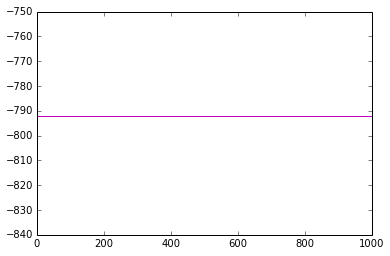

In [61]:
temperatures=[1,25,50,100,1000]
for T in temperatures:
    x_values, budgets = simulated_annealing(PELiHJW, T, 0.9, 0.0001, 2000, 20, 20)
    print 'the algorithm takes: ',len(budgets),' iterations with T:',T
    plt.plot(budgets)
    print 'the lowest value found for T=',T,'is:',budgets[len(budgets)-1]
plt.show()

In [71]:
molecule='H2'
basis='NMO'
coeff,op=commutators.GetHamiltonianTerms(molecule, basis, add_conjugates=True, path='/home/jonathan/quantum_computation/data/')
hamiltonianH2=symbolicCircuits.getHamiltonianJW(coeff,op,4)
print len(hamiltonianH2)
counter=0
depth=0
PEH2=[]
counter=0
for t in hamiltonianH2:
    counter += 1
    if counter!=1:
        print t.printTerm()
        depth += t.printTerm3()
        c = symbolicCircuits.buildExpCircuit3(1.0,t)
        PEH2.append(c)
print 'The depth of the circuit',depth

15
((1.0797747583434125+0j), 'Z0I1I2I3')
((1.0797747583434125+0j), 'I0Z1I2I3')
((0.702920151712927+0j), 'I0I1Z2I3')
((0.702920151712927+0j), 'I0I1I2Z3')
((-0.16819661852139076+0j), 'Z0Z1I2I3')
((-0.12014567801253392+0j), 'Z0I1Z2I3')
((-0.16566073965958383+0j), 'I0Z1Z2I3')
((-0.16566073965958383+0j), 'Z0I1I2Z3')
((-0.12014567801253392+0j), 'I0Z1I2Z3')
((-0.17433760124527006+0j), 'I0I1Z2Z3')
((0.0455150616470499+0j), 'X0X1Y2Y3')
((-0.0455150616470499+0j), 'Y0X1X2Y3')
((-0.0455150616470499+0j), 'X0Y1Y2X3')
((0.0455150616470499+0j), 'Y0Y1X2X3')
The depth of the circuit 272


stopped with itol
atp: 10001
the algorithm takes:  308  iterations with T: 8
the lowest value found for T= 8 is: -8
stopped with itol
atp: 10001
the algorithm takes:  361  iterations with T: 6
the lowest value found for T= 6 is: -8
stopped with itol
atp: 10001
the algorithm takes:  142  iterations with T: 4
the lowest value found for T= 4 is: -8
stopped with itol
atp: 10001
the algorithm takes:  97  iterations with T: 1
the lowest value found for T= 1 is: -8
stopped with itol
atp: 10001
the algorithm takes:  64  iterations with T: 8
the lowest value found for T= 8 is: -8
stopped with itol
atp: 10001
the algorithm takes:  265  iterations with T: 6
the lowest value found for T= 6 is: -8
stopped with itol
atp: 10001
the algorithm takes:  183  iterations with T: 4
the lowest value found for T= 4 is: -8
stopped with itol
atp: 10001
the algorithm takes:  126  iterations with T: 1
the lowest value found for T= 1 is: -8


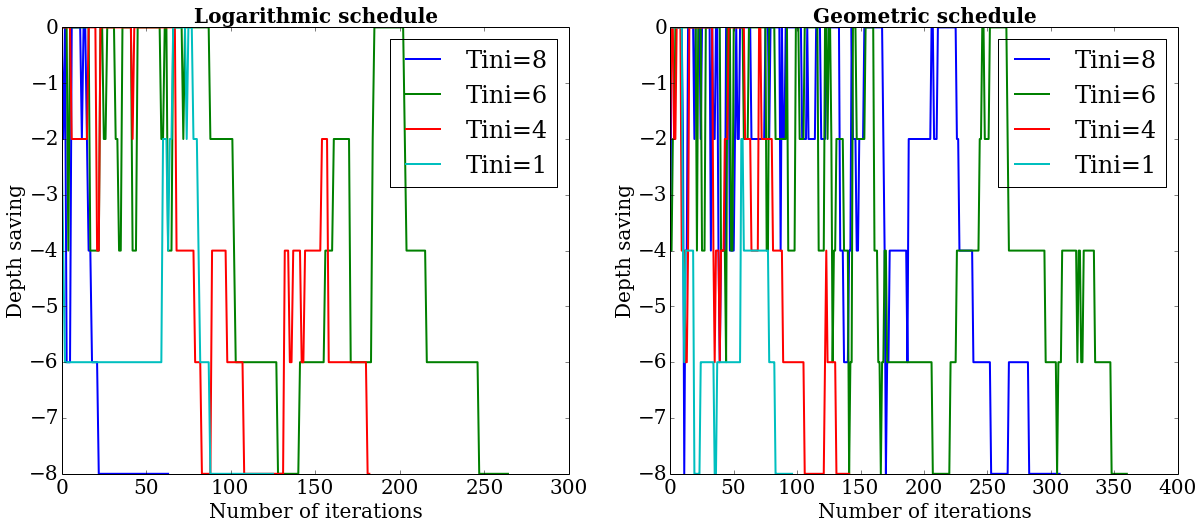

In [73]:
x_init=getPermutation(PEH2,8)
plt.figure(1, figsize=(20,8))
ramp=[' linear ramp',]
temperatures=[[8,6,4,1],[8,6,4,1]]
for counter in range(0,2):
    if counter==0:
        ramp='Geometric schedule'
    elif counter==1:
        ramp='Logarithmic schedule'
    for T in temperatures[counter]:
        x_values, budgets = simulated_annealing(x_init, T, 0.9, 0.05, 10000, -5000, 10, counter)
        print 'the algorithm takes: ',len(budgets),' iterations with T:',T
        plt.subplot(1, 2, counter)
        plt.title(ramp, fontsize=20, fontweight='bold')
        plt.plot(budgets, label='Tini='+str(T), linewidth=2.0)
        plt.ylabel('Depth saving'); plt.xlabel('Number of iterations')
        plt.legend()
        print 'the lowest value found for T=',T,'is:',budgets[len(budgets)-1]
plt.show()

In [66]:
print getTotalCancellations(getPermutation(PEH2,10))

-12
